<a href="https://colab.research.google.com/github/Kozhedu/Car_Moldova/blob/main/%D0%9B%D0%B8%D0%BD%D0%B5%D0%B9%D0%BD%D0%B0%D1%8F_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNetCV

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split

from sklearn import linear_model
from  sklearn.pipeline  import  make_pipeline 

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate

# Cинтетическиe данныe

Создается функция для генерации линейных и полиномиальных зависимостей

In [ ]:
def true_fun(x, a=np.pi, b = 0, f=np.sin): #функция создает одномерные данные от входных данных X
    x = np.atleast_1d(x)[:]
    a = np.atleast_1d(a)
    
    if f is None: f = lambda x:x # line
    x = np.sum([ai*np.power(x, i+1) for i,ai in enumerate(a)],axis=0)

    return f(x+ b)

def noises(shape , noise_power): #функция которая генерирует шум
    return np.random.randn(*shape) *noise_power

def dataset(a, b, f = np.exp,  N = 250, x_max =1, noise_power = 0, random_x = True,  seed = 42): #итоговая функция для генерации синтетических данных
    np.random.seed(seed)
    
    if random_x:
        x = np.sort(np.random.rand(N))*x_max    
    else:
        x = np.linspace(0,x_max,N)
    
    y_true = np.array([])
    
    for f_ in np.append([], f):
        y_true=np.append(y_true, true_fun(x, a, b, f_))
    
    y_true = y_true.reshape(-1,N).T
    y = y_true + noises(y_true.shape , noise_power)

    return y, y_true, np.atleast_2d(x).T


In [ ]:
def vis_data(y, y_true,x, title): #функция для построения графиков
    fig  = plt.figure(figsize=(15,7))
    plt.scatter(x[:,0], y, edgecolor='b', label="Зашумленные Данные",s=196, alpha = 0.6)
    plt.scatter(x[:,0], y_true,label="Реальные Данные", s=81,c='g', alpha = 0.8)
    plt.grid()
    plt.xlabel('x',fontsize=35)
    plt.ylabel('y',fontsize=35)
    plt.legend(fontsize=25)
    plt.title(title, fontsize=25 )
    plt.xticks(FontSize = 25)
    plt.yticks(FontSize = 25);
    plt.tight_layout()

In [ ]:
def plot_model_class(x_train, y_train, x_test, x, y, model):
    plt.plot(x_train[:,0], model.predict(x_train),
            '.', label='Предсказание на x_train',
            markersize = 15)
    plt.plot(x_test[:,0], model.predict(x_test),
            'o', label='Предсказание на x_test',
            markersize = 15, alpha =0.8)
    plt.plot(x_train[:,0], y_train, '.',
            label="Тренировочные данные", linewidth=2,c='r')
    plt.plot(x[:,0], y, '--',
            label="Истинные Значения", linewidth=4,c='g')
    plt.legend(fontsize=20); plt.grid()
    plt.xlabel('x',fontsize=35)
    plt.ylabel('y',fontsize=35);
    plt.xticks(FontSize = 25)
    plt.yticks(FontSize = 25);

## 1. Линейная  зависимость

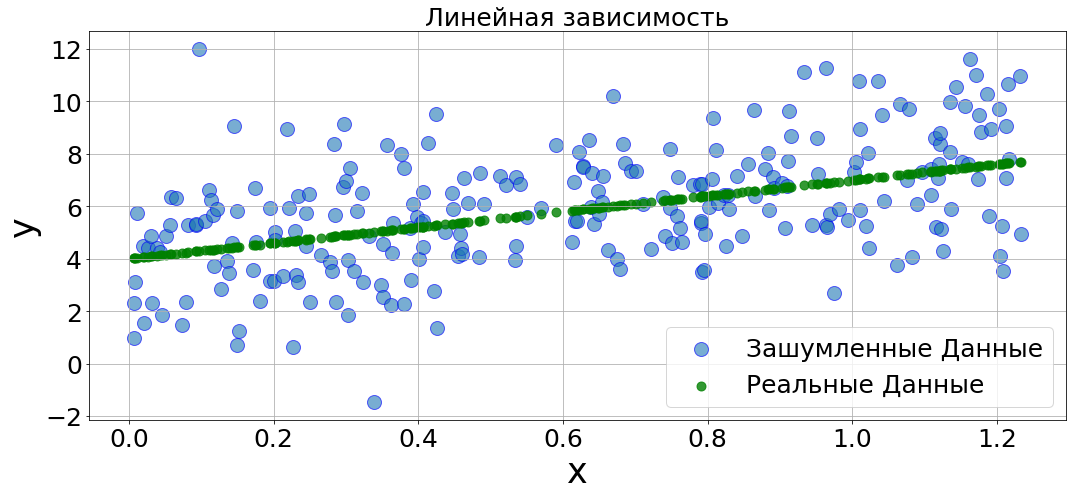

In [ ]:
noise_power = 0.1

y_lin, y_true_lin, x_lin = dataset(a = 3, b = 4,
                       f = None,  N = 250,
                       x_max =1.25, 
                       noise_power = 2,
                       seed = 42)
vis_data(y_lin, y_true_lin, x_lin, 'Линейная зависимость')

### 1.1. Простая линейная модель

Для простой линейной зависимости я использовала библиотеку - sklearn

In [ ]:
print(x_lin.shape)
print(y_lin.shape)

(250, 1)
(250, 1)


In [ ]:
#1. Разбиваем данные на обучающую и тестовую выборку
x_train_lin, x_test_lin, y_train_lin, y_test_lin = train_test_split(x_lin, y_lin, test_size=0.3, random_state=42)  

#Маштабирование данных производится т.к. чем больше значение, тем модель придает данным значениям большие веса, необходимо провести масштабирование признаков
scaler  = MinMaxScaler()
scaler.fit_transform(x_train_lin)
x_train_lin = scaler.transform(x_train_lin) 
x_test_lin  = scaler.transform(x_test_lin)

In [ ]:
# 3. Создаем объект линейной регрессии и обучаем
lin_reg = LinearRegression() 
lin_reg.fit(x_train_lin, y_train_lin)
y_predict = lin_reg.predict(x_test_lin)

In [ ]:
#Параметры «наклона» (w), также называемые весами или коэффициентами (coefficients), хранятся в атрибуте coef_, 
#тогда как сдвиг (offset) или константа (intercept), хранится в атрибуте intercept_:
B0=lin_reg.intercept_
B=lin_reg.coef_

print("lr.coef_: {}".format(lin_reg.coef_))
print("lr.intercept_: {}".format(lin_reg.intercept_))

lr.coef_: [[3.87189859]]
lr.intercept_: [4.02401938]


Атрибут intercept_ - это всегда отдельное число с плавающей точкой, тогда как атрибут coef_ - это массив NumPy, в котором каждому элементу соответствует входной признак.

In [ ]:
#Проводим кросс-валидацию
scoring = {'R2': 'r2',
           '-MSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           'Max': 'max_error'}


scores = cross_validate(lin_reg, x_train_lin, y_train_lin,
                      scoring=scoring, cv=ShuffleSplit(n_splits=5, random_state=42) )

print('Результаты Кросс-валидации')
DF_cv_linreg = pd.DataFrame(scores)
display(DF_cv_linreg)
print('\n')
print(DF_cv_linreg.mean()[2:])
print('\n')

Результаты Кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_Max
0,0.001600,0.001764,-0.013685,-6.210810,-1.714264,-7.783564
1,0.001232,0.002427,0.089111,-2.614363,-1.300096,-4.253620
2,0.001434,0.002878,0.246454,-3.346725,-1.557259,-3.510186
3,0.002755,0.005388,-0.128920,-2.546912,-1.301035,-3.766501
4,0.001430,0.001165,0.213066,-4.403801,-1.781303,-3.691481




test_R2      0.081205
test_-MSE   -3.824522
test_-MAE   -1.530792
test_Max    -4.601070
dtype: float64




In [ ]:
#Оцениваем результат
lin_reg.fit(x_train_lin, y_train_lin)
y_predict_lin=lin_reg.predict(x_test_lin)

print('Ошибка на тестовых данных')
print('MSE: %.1f' % mse(y_test_lin,y_predict_lin))
print('RMSE: %.1f' % mse(y_test_lin,y_predict_lin,squared=False))
print('R2 : %.4f' %  r2_score(y_test_lin,y_predict_lin))

Ошибка на тестовых данных
MSE: 3.6
RMSE: 1.9
R2 : 0.2874


In [ ]:
y_lin.max()-y_lin.min()

13.459113454153453

In [ ]:
lin_reg.score(x_train_lin, y_train_lin)

0.24932640871984446

Вывод: Модель очень плохо работает об этом говорят R2 и score а так-же MSE и RMSE

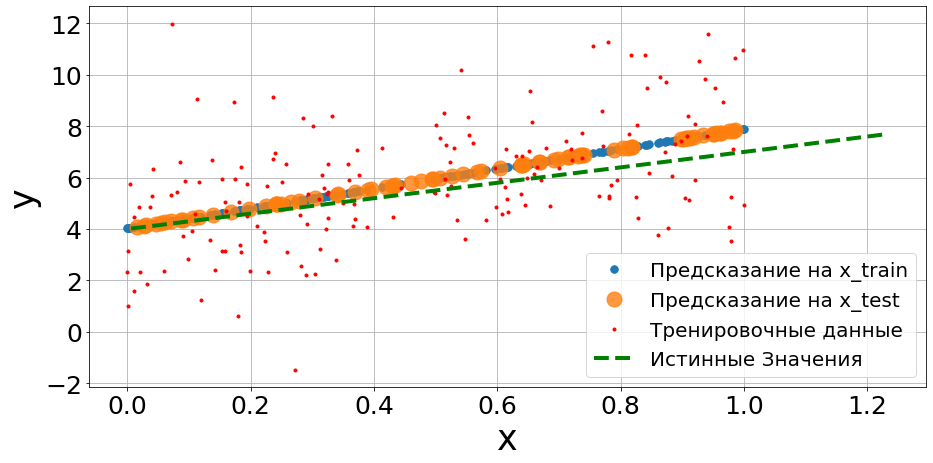

In [ ]:
#Визуализируем результат
fig  = plt.figure(figsize=(15,7))
plot_model_class(x_train_lin, y_train_lin,  x_test_lin, x_lin, y_true_lin, lin_reg)

*LinearRegression  - fit_intercept - пояснение*

Парамент fit_intercept указывает - присутсвует ли в модели свободный член или отсутсвует. Если fit_intercept = False - то свободного члена нет, если True - свободный член есть.

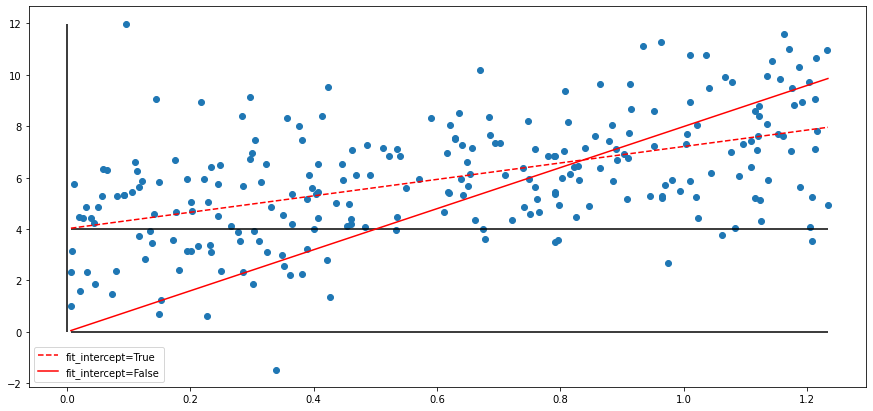

In [ ]:
lr_fi_true = LinearRegression(fit_intercept=True)
lr_fi_false = LinearRegression(fit_intercept=False)

lr_fi_true.fit(x_lin, y_lin)
lr_fi_false.fit(x_lin, y_lin)


lr_fi_true_yhat = np.dot(x_lin, lr_fi_true.coef_) + lr_fi_true.intercept_
lr_fi_false_yhat = np.dot(x_lin, lr_fi_false.coef_) + lr_fi_false.intercept_

fig  = plt.figure(figsize=(15,7))
plt.scatter(x_lin, y_lin)
plt.plot(x_lin, lr_fi_true_yhat, 'r--', label='fit_intercept=True')
plt.plot(x_lin, lr_fi_false_yhat, 'r-', label='fit_intercept=False')
plt.legend()

plt.vlines(0, 0, y_lin.max())
plt.hlines(4, x_lin.min(), x_lin.max())
plt.hlines(0, x_lin.min(), x_lin.max())

plt.show()

Когда fit_intercept=True линия соответсвует оси Y. При fit_intercept=False начало линии принудительно перемещается в начало координат (0, 0). По умолчанию - fit_intercept=True 

Маштабирование данных производится т.к. чем больше значение, тем модель придает данным значениям большие веса, необходимо провести масштабирование признаков

### 1.2. Регуларизация Ridge ( L2 регуляризация)

In [ ]:
ridge = Ridge()
ridge0001 = Ridge(alpha=.0001)
ridge001 = Ridge(alpha=.001)
ridge01 = Ridge(alpha=.01)
ridge10 = Ridge(alpha=10)
ridge100 = Ridge(alpha=100)

In [ ]:
ridge.fit(x_lin, y_lin)
ridge0001.fit(x_lin, y_lin)
ridge001.fit(x_lin, y_lin)
ridge01.fit(x_lin, y_lin)
ridge10.fit(x_lin, y_lin)
ridge100.fit(x_lin, y_lin)

Ridge(alpha=100)

In [ ]:
lr_fi_1_yhat = np.dot(x_lin, ridge.coef_) + ridge.intercept_
lr_fi_0001_yhat = np.dot(x_lin, ridge0001.coef_) + ridge0001.intercept_
lr_fi_001_yhat = np.dot(x_lin, ridge001.coef_) + ridge001.intercept_
lr_fi_01_yhat = np.dot(x_lin, ridge01.coef_) + ridge01.intercept_
lr_fi_10_yhat = np.dot(x_lin, ridge10.coef_) + ridge10.intercept_
lr_fi_100_yhat = np.dot(x_lin, ridge100.coef_) + ridge100.intercept_

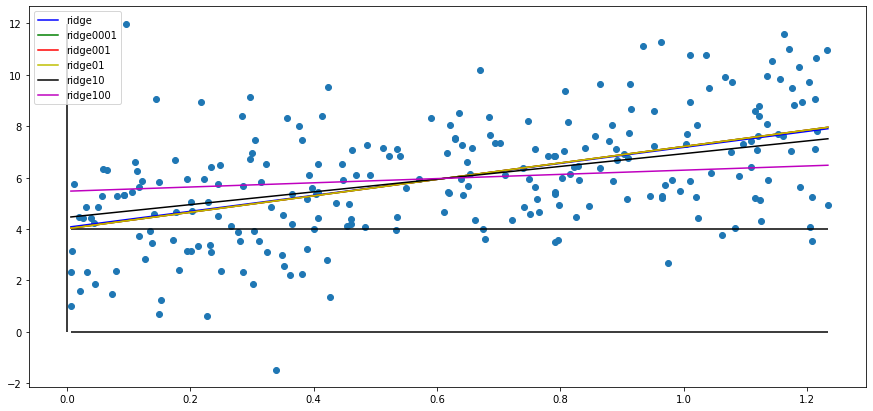

In [ ]:
fig  = plt.figure(figsize=(15,7))
plt.scatter(x_lin, y_lin)
plt.plot(x_lin, lr_fi_1_yhat, 'r-', label='ridge', color='b')
plt.plot(x_lin, lr_fi_0001_yhat, 'r-', label='ridge0001', color='g')
plt.plot(x_lin, lr_fi_001_yhat, 'r-', label='ridge001', color='r')
plt.plot(x_lin, lr_fi_01_yhat, 'r-', label='ridge01', color='y')
plt.plot(x_lin, lr_fi_10_yhat, 'r-', label='ridge10', color='k')
plt.plot(x_lin, lr_fi_100_yhat, 'r-', label='ridge100', color='m')

plt.legend()

plt.vlines(0, 0, y_lin.max())
plt.hlines(4, x_lin.min(), x_lin.max())
plt.hlines(0, x_lin.min(), x_lin.max())

plt.show()

Лучшие показатели у модели с alpha=0.0001, тогда, как alpha=100 значительно искажает прогноз. т.е. чем меньше alpha, тем модель лучше учится. При этом существует высокая вероятность переобучение модели при низком alpha, однако при линейной модели чем ниже  alpha тем лучше

In [ ]:
#Оцениваем результат
ridge0001 = linear_model.Ridge(alpha=5) #Возьмем alpha=5, для того, чтобы посмотреть как будет вести себя модель не на минимальных значениях альфа
ridge0001.fit(x_train_lin, y_train_lin)
y_predict_rid = ridge0001.predict(x_test_lin)
print('Ошибка на тестовых данных')
print('MSE: %.1f' % mse(y_test_lin,y_predict_rid))
print('RMSE: %.1f' % mse(y_test_lin,y_predict_rid,squared=False))
print('R2 : %.4f' %  r2_score(y_test_lin,y_predict_rid))

Ошибка на тестовых данных
MSE: 3.7
RMSE: 1.9
R2 : 0.2645


In [ ]:
lin_reg.score(x_train_lin, y_train_lin)

0.24932640871984446

Вывод:  Регуларизация Ridge не дала ожидаемых результатов - Модель очень плохо работает об этом говорят R2 и score а так-же MSE и RMSE

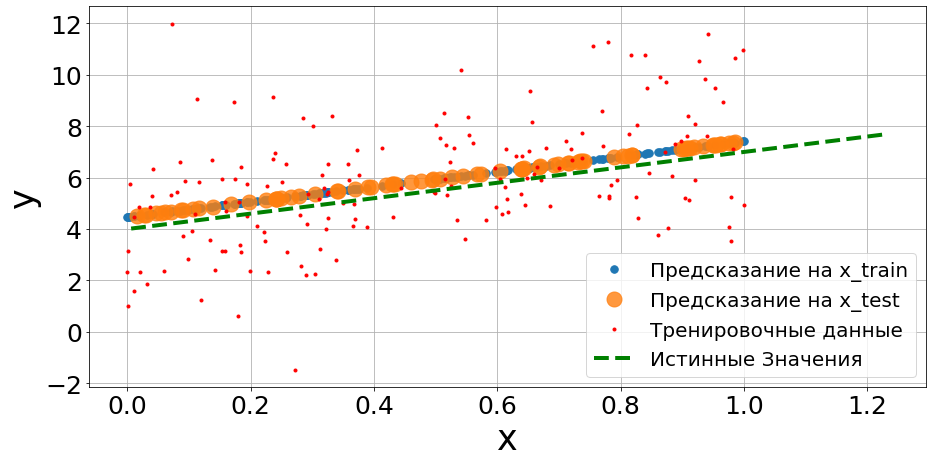

In [ ]:
fig  = plt.figure(figsize=(15,7))
plot_model_class(x_train_lin, y_train_lin,  x_test_lin, x_lin, y_true_lin, ridge0001)

### 1.3. Регуларизация Lasso (L1 регуляризация)

т.к. ранее было понятно, что для простой линейной модели чем ниже  alpha тем лучше, установим сразу низкие показатели alpha и для L1 регуляризации

In [ ]:
lasso00001 = linear_model.Lasso(alpha=0.0001, max_iter=10000)
lasso00001.fit(x_train_lin, y_train_lin)
y_predict_las = lasso00001.predict(x_test_lin)

print('Ошибка на тестовых данных')
print('MSE: %.1f' % mse(y_test_lin,y_predict_las))
print('RMSE: %.1f' % mse(y_test_lin,y_predict_las,squared=False))
print('R2 : %.4f' %  r2_score(y_test_lin,y_predict_las))

Ошибка на тестовых данных
MSE: 3.6
RMSE: 1.9
R2 : 0.2874


Вывод:  Регуларизация Lasso не дала ожидаемых результатов - Модель очень плохо работает об этом говорят R2 и score а так-же MSE и RMSE

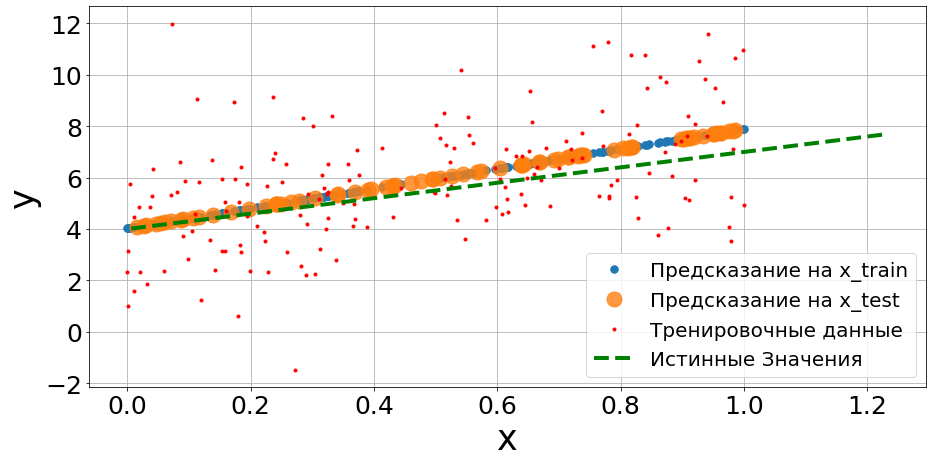

In [ ]:
fig  = plt.figure(figsize=(15,7))
plot_model_class(x_train_lin, y_train_lin,  x_test_lin, x_lin, y_true_lin, lasso00001)

## 2. Кубическая полиномиальная зависимость

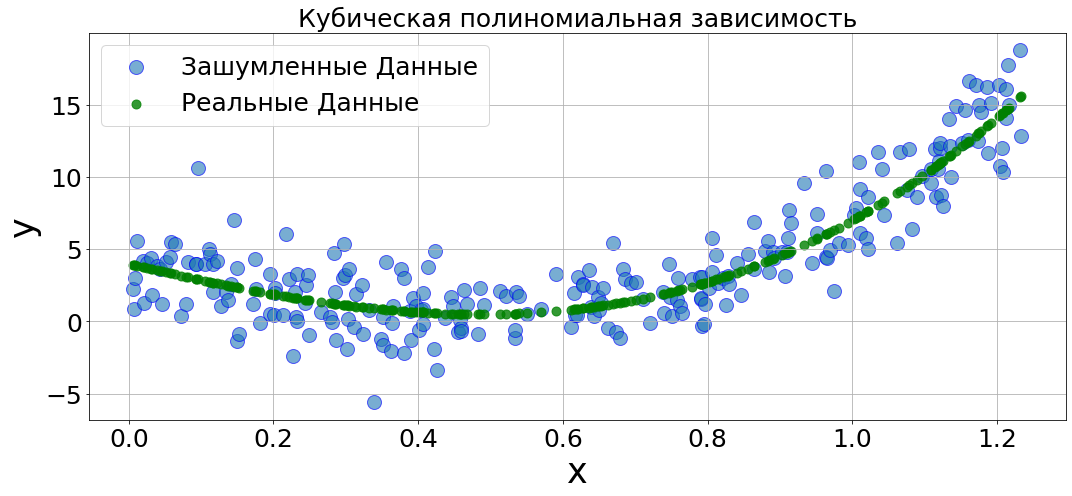

In [ ]:
noise_power = 0.1

y_cub, y_true_cub, x_cub = dataset(a = [-12,5,10], b = 4,
                       f = None,  N = 250,
                       x_max =1.25, 
                       noise_power = 2,
                       seed = 42)
vis_data(y_cub, y_true_cub, x_cub, 'Кубическая полиномиальная зависимость')

### 2.1. Построение базовой модели

In [ ]:
#Разбиваем данные на обучающую и тестовую выборку
x_train_cub, x_test_cub, y_train_cub, y_test_cub= train_test_split(x_cub, y_cub, test_size=0.3, random_state=42) 


In [ ]:
# 3. Создаем объект линейной регрессии и обучаем
lin_reg_cub = LinearRegression() 
lin_reg_cub.fit(x_train_cub, y_train_cub)
y_predict = lin_reg.predict(x_test_cub)

In [ ]:
#устанавливаем степень полиномиальной функции, т.к у нас функция  кубическая, то degree =3
model = Pipeline([('poly', PolynomialFeatures(degree=3)), ('linear', LinearRegression(fit_intercept=False))])
model.fit(x_train_cub, y_train_cub)
y_predict_cub = model.predict(x_test_cub)

In [ ]:
print('Ошибка на тестовых данных')
print('MSE: %.1f' % mse(y_test_cub,y_predict_cub))
print('RMSE: %.1f' % mse(y_test_cub,y_predict_cub,squared=False))
print('R2 : %.4f' %  r2_score(y_test_cub,y_predict_cub))

Ошибка на тестовых данных
MSE: 3.7
RMSE: 1.9
R2 : 0.8496


In [ ]:
model.score(x_train_cub, y_train_cub)

0.7942008767222942

Вывод: Модель работает уже очень хорошо.

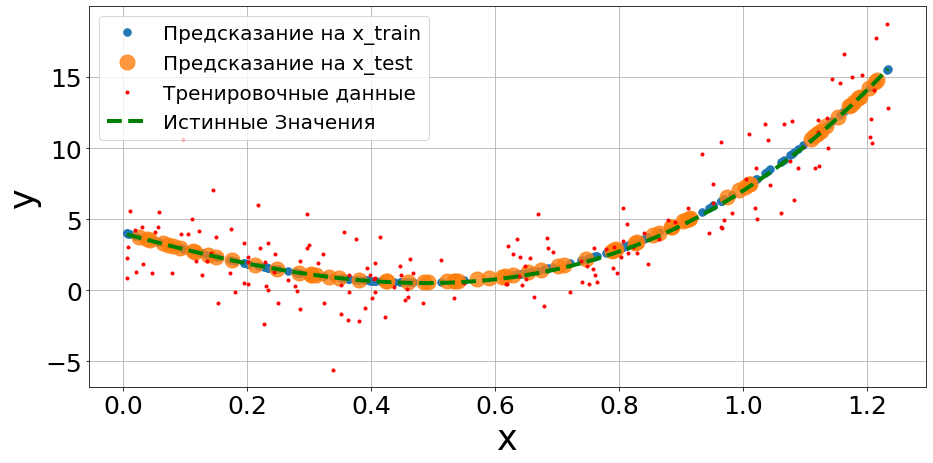

In [ ]:
#Оцениваем результат
fig  = plt.figure(figsize=(15,7))

plot_model_class(x_train_cub, y_train_cub,  x_test_cub, x_cub, y_true_cub, model)

Если посмотреть на ошибку обучения и тестирования как на функцию степени полинома - то видно, то  чем выше степень полинома, тем меньше ошибка обучения. Погрешность тестирования тоже уменьшается.

In [ ]:
train_error = np.empty(10)
test_error = np.empty(10)
for degree in range(10):
  est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
  est.fit(x_train_cub, y_train_cub)
  train_error[degree] = mean_squared_error(y_train_cub, est.predict(x_train_cub))
  test_error[degree] = mean_squared_error(y_test_cub, est.predict(x_test_cub))

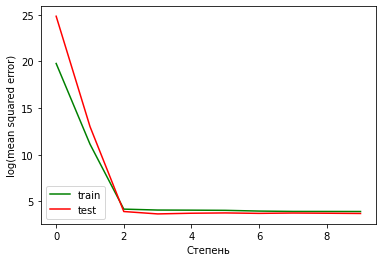

In [ ]:
plt.plot(np.arange(10), train_error, color='green', label='train')
plt.plot(np.arange(10), test_error, color='red', label='test')

plt.ylabel('log(mean squared error)')
plt.xlabel('Степень')
plt.legend(loc='lower left')

Соответсвенно для данной моедли степень полинома выбранна верно.

### 2.2. Регуляризация Lasso

In [ ]:
est = make_pipeline(PolynomialFeatures(degree=3), Lasso(alpha=0.005))
est.fit(x_train_cub, y_train_cub)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('lasso', Lasso(alpha=0.005))])

In [ ]:
y_predict_est = est.predict(x_test_cub)

print('Ошибка на тестовых данных')
print('MSE: %.1f' % mse(y_test_cub,y_predict_est))
print('RMSE: %.1f' % mse(y_test_cub,y_predict_est,squared=False))
print('R2 : %.4f' %  r2_score(y_test_cub,y_predict_est))

Ошибка на тестовых данных
MSE: 3.6
RMSE: 1.9
R2 : 0.8506


In [ ]:
est.score(x_train_cub, y_train_cub)

0.792815786107238

Модель улучилась, но не намного.

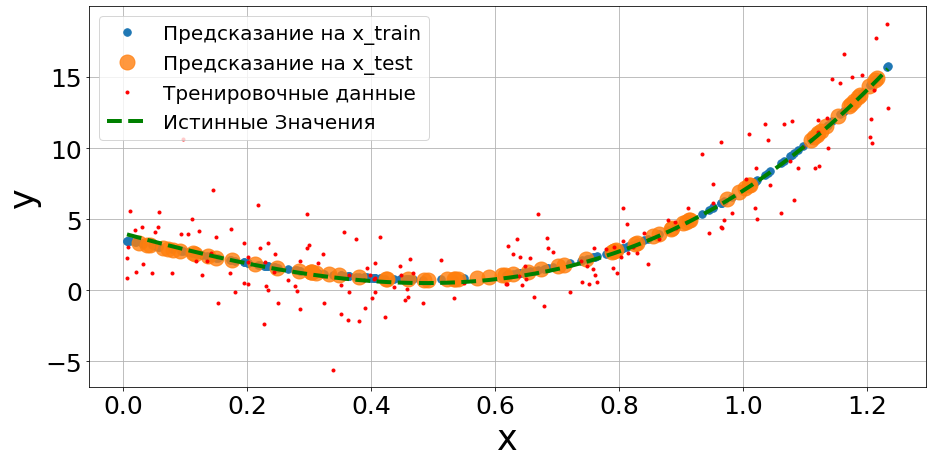

In [ ]:
#Оцениваем результат
fig  = plt.figure(figsize=(15,7))

plot_model_class(x_train_cub, y_train_cub,  x_test_cub, x_cub, y_true_cub, est)

### 2.3.  Линейная регрессия с объединенными априорными значениями L1 и L2 в качестве регуляризатора.

In [ ]:
ent = make_pipeline(PolynomialFeatures(degree=3), ElasticNetCV(cv=5, random_state=0))
ent.fit(x_train_cub, y_train_cub)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('elasticnetcv', ElasticNetCV(cv=5, random_state=0))])

In [ ]:
y_predict_ent = ent.predict(x_test_cub)

print('Ошибка на тестовых данных')
print('MSE: %.1f' % mse(y_test_cub,y_predict_ent))
print('RMSE: %.1f' % mse(y_test_cub,y_predict_ent,squared=False))
print('R2 : %.4f' %  r2_score(y_test_cub,y_predict_ent))

Ошибка на тестовых данных
MSE: 3.8
RMSE: 1.9
R2 : 0.8451


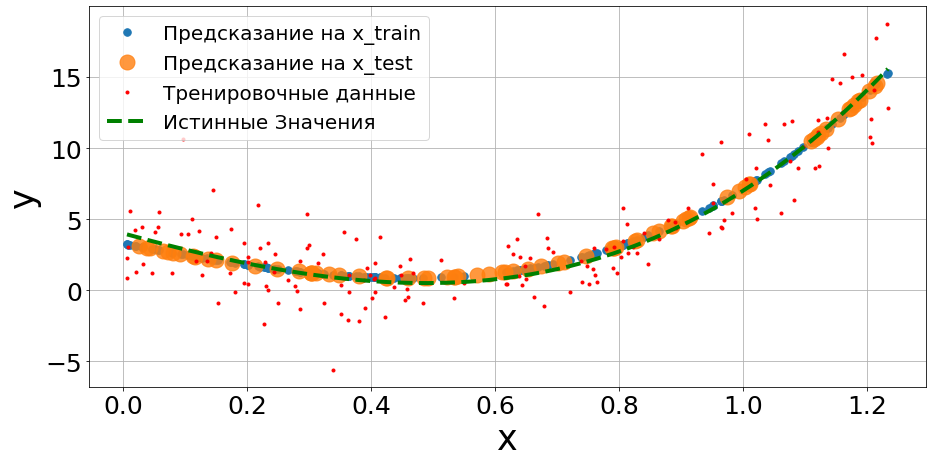

In [ ]:
#Оцениваем результат
fig  = plt.figure(figsize=(15,7))

plot_model_class(x_train_cub, y_train_cub,  x_test_cub, x_cub, y_true_cub, ent)

Данная модель показала результаты гораздо хуже, чем модель со степенью полинома =3 и регуляризацией Lasso

## 3. Гармоническая зависимость (sin)

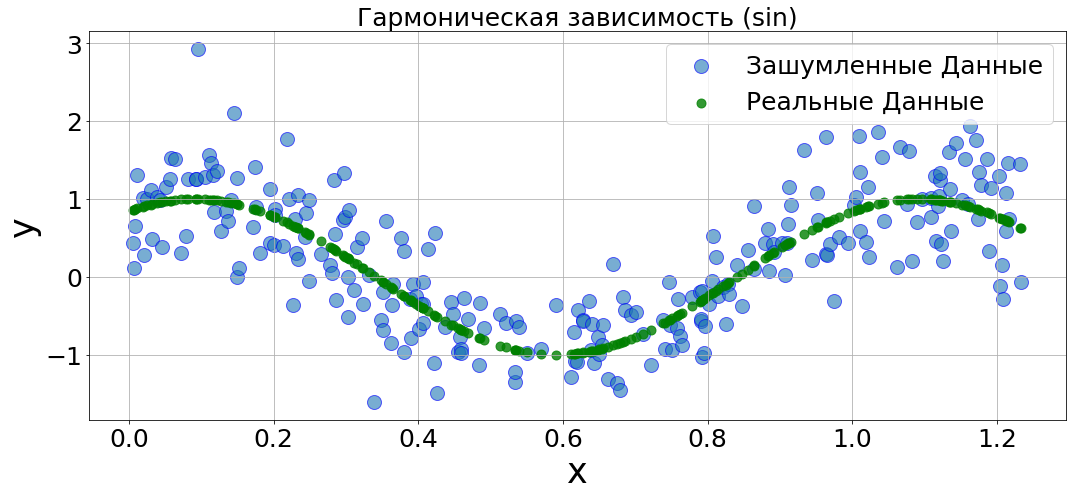

In [ ]:
noise_power = 0.1

y_pol, y_true_pol, x_pol = dataset(a = 2*np.pi, b = 1,
                       f = np.sin,  N = 250,
                       x_max =1.25, 
                       noise_power = 0.5,
                       seed = 42)
vis_data(y_pol, y_true_pol, x_pol, 'Гармоническая зависимость (sin)')

### 3.1. Построение базовой модели

In [ ]:
#Разбиваем данные на обучающую и тестовую выборку
x_train_pol, x_test_pol, y_train_pol, y_test_pol= train_test_split(x_pol, y_pol, test_size=0.3, random_state=42) 

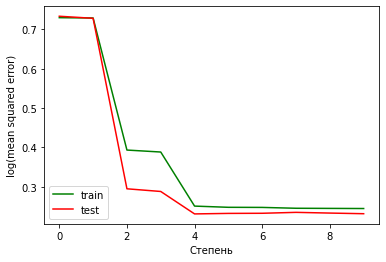

In [ ]:
#посмотрим какой полином применить
train_error = np.empty(10)
test_error = np.empty(10)
for degree in range(10):
  est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
  est.fit(x_train_pol, y_train_pol)
  train_error[degree] = mean_squared_error(y_train_pol, est.predict(x_train_pol))
  test_error[degree] = mean_squared_error(y_test_pol, est.predict(x_test_pol))

plt.plot(np.arange(10), train_error, color='green', label='train')
plt.plot(np.arange(10), test_error, color='red', label='test')

plt.ylabel('log(mean squared error)')
plt.xlabel('Степень')
plt.legend(loc='lower left')

In [ ]:
#устанавливает степень полиномиальной функции=5
model_pol = Pipeline([('poly', PolynomialFeatures(degree=5 )), ('linear', LinearRegression(fit_intercept=False))])
model_pol.fit(x_train_pol, y_train_pol)
y_predict_pol = model_pol.predict(x_test_pol)

In [ ]:
print('Ошибка на тестовых данных')
print('MSE: %.1f' % mse(y_test_pol, y_predict_pol))
print('RMSE: %.1f' % mse(y_test_pol, y_predict_pol,squared=False))
print('R2 : %.4f' %  r2_score(y_test_pol, y_predict_pol))

Ошибка на тестовых данных
MSE: 0.2
RMSE: 0.5
R2 : 0.6833


Результатаы не очень хорошие. Попробуем улучшить модель за счет регуляризации.

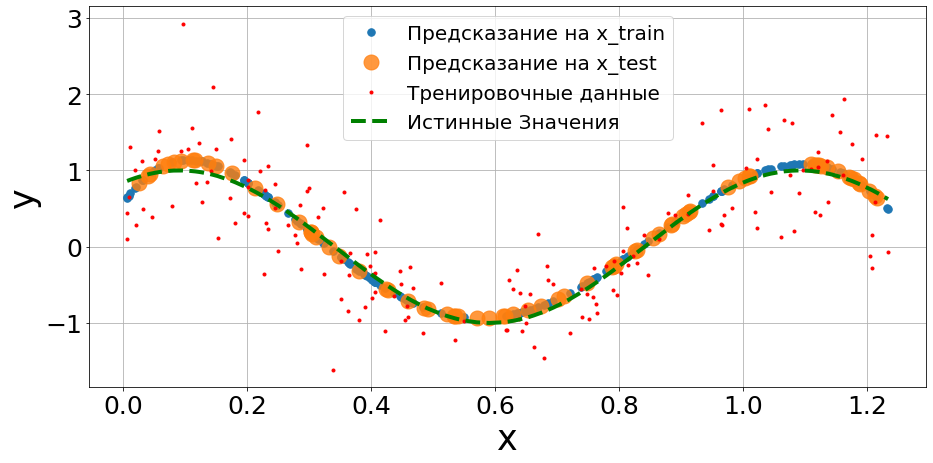

In [ ]:
#Оцениваем результат
fig  = plt.figure(figsize=(15,7))

plot_model_class(x_train_pol, y_train_pol,  x_test_pol, x_pol, y_true_pol, model_pol)

### 3.2. Регуларизация Ridge ( L2 регуляризация)

In [ ]:
rid_pol = make_pipeline(PolynomialFeatures(degree=5), Ridge(alpha=0.0001))
rid_pol.fit(x_train_pol, y_train_pol)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=5)),
                ('ridge', Ridge(alpha=0.0001))])

In [ ]:
y_predict_rid_pol = rid_pol.predict(x_test_pol)

print('Ошибка на тестовых данных')
print('MSE: %.1f' % mse(y_test_pol, y_predict_rid_pol))
print('RMSE: %.1f' % mse(y_test_pol, y_predict_rid_pol,squared=False))
print('R2 : %.4f' %  r2_score(y_test_pol, y_predict_rid_pol))

Ошибка на тестовых данных
MSE: 0.2
RMSE: 0.5
R2 : 0.6874


После регуляризации модель улучшилась, но не значительно

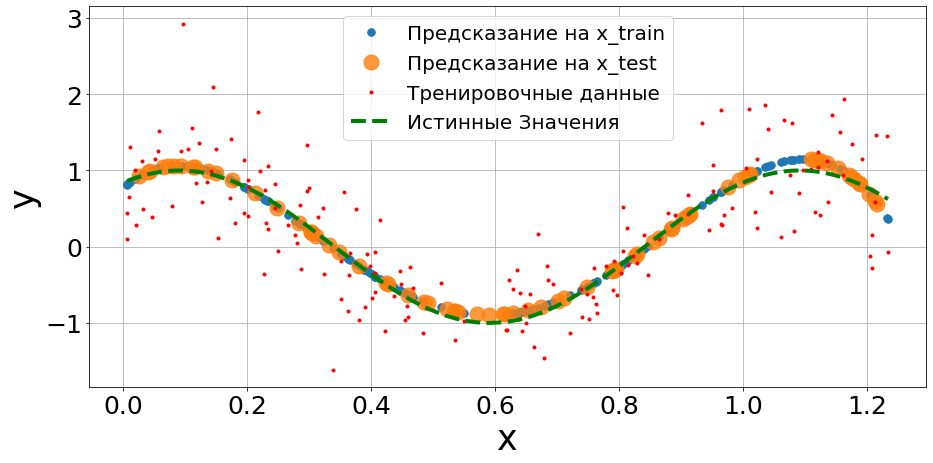

In [ ]:
#Оцениваем результат
fig  = plt.figure(figsize=(15,7))

plot_model_class(x_train_pol, y_train_pol,  x_test_pol, x_pol, y_true_pol, rid_pol)

## 4. Гармоническая зависимость (exp)

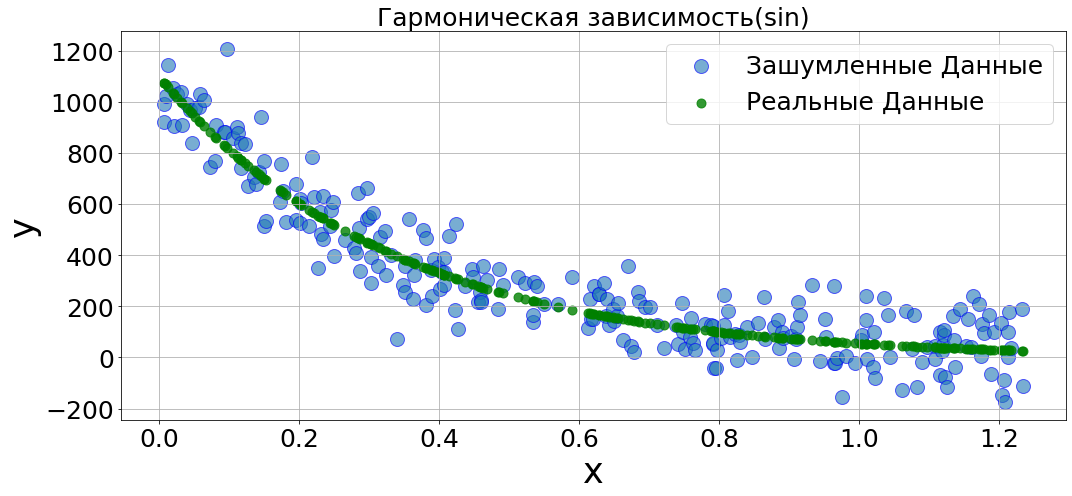

In [ ]:
noise_power = 0.1

y_exp, y_true_exp, x_exp = dataset(a = -3, b = 7,
                       f = np.exp,  N = 250,
                       x_max =1.25, 
                       noise_power = 100,
                       seed = 42)
vis_data(y_exp, y_true_exp, x_exp,  'Гармоническая зависимость(sin)')

### 4.1. Построение базовой модели

In [ ]:
#Разбиваем данные на обучающую и тестовую выборку
x_train_exp, x_test_exp, y_train_exp, y_test_exp= train_test_split(x_exp, y_exp, test_size=0.3, random_state=42) 

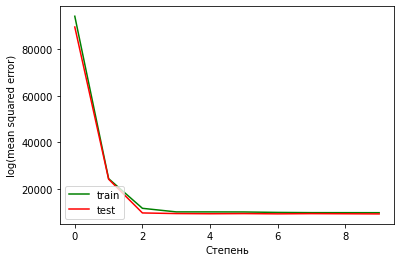

In [ ]:
#посмотрим какой полином применить
train_error = np.empty(10)
test_error = np.empty(10)
for degree in range(10):
  est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
  est.fit(x_train_exp, y_train_exp)
  train_error[degree] = mean_squared_error(y_train_exp, est.predict(x_train_exp))
  test_error[degree] = mean_squared_error(y_test_exp, est.predict(x_test_exp))

plt.plot(np.arange(10), train_error, color='green', label='train')
plt.plot(np.arange(10), test_error, color='red', label='test')

plt.ylabel('log(mean squared error)')
plt.xlabel('Степень')
plt.legend(loc='lower left')

In [ ]:
#устанавливает степень полиномиальной функции=3
model_exp = Pipeline([('poly', PolynomialFeatures(degree=3 )), ('linear', LinearRegression(fit_intercept=False))])
model_exp.fit(x_train_exp, y_train_exp)
y_predict_exp = model_exp.predict(x_test_exp)

In [ ]:
print('Ошибка на тестовых данных')
print('MSE: %.1f' % mse(y_test_exp, y_predict_exp))
print('RMSE: %.1f' % mse(y_test_exp, y_predict_exp,squared=False))
print('R2 : %.4f' %  r2_score(y_test_exp, y_predict_exp))

Ошибка на тестовых данных
MSE: 9413.6
RMSE: 97.0
R2 : 0.8934


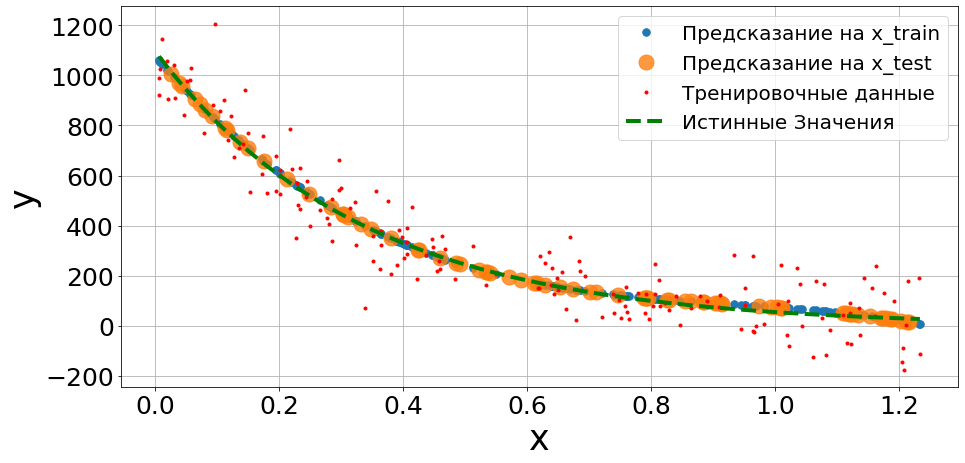

In [ ]:
#Оцениваем результат
fig  = plt.figure(figsize=(15,7))

plot_model_class(x_train_exp, y_train_exp,  x_test_exp, x_exp, y_true_exp, model_exp)

Модель отработала очень хорошо. 

### 4.2. Регуляризация Lasso

In [ ]:
est_exp = make_pipeline(PolynomialFeatures(degree=3), Lasso(alpha=0.005))
est_exp.fit(x_train_exp, y_train_exp)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.751e+05, tolerance: 1.648e+03
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('lasso', Lasso(alpha=0.005))])

In [ ]:
y_predict_est_exp = est_exp.predict(x_test_exp)

print('Ошибка на тестовых данных')
print('MSE: %.1f' % mse(y_test_exp, y_predict_est_exp))
print('RMSE: %.1f' % mse(y_test_exp, y_predict_est_exp,squared=False))
print('R2 : %.4f' %  r2_score(y_test_exp, y_predict_est_exp))

Ошибка на тестовых данных
MSE: 9308.8
RMSE: 96.5
R2 : 0.8946


Модель после регуляризации работает немного лучше.

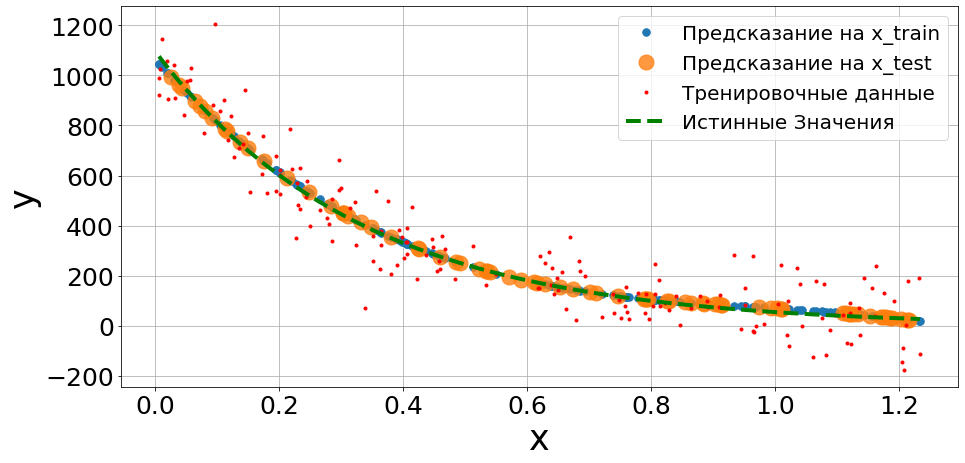

In [ ]:
#Оцениваем результат
fig  = plt.figure(figsize=(15,7))

plot_model_class(x_train_exp, y_train_exp,  x_test_exp, x_exp, y_true_exp, est_exp)

# Cars Moldova

## 1. Прогноз на очищенных от дубликатов и выбросов, с добавленными признаками из «Задания 1»

In [ ]:
df = pd.read_csv("cars_moldova_categor.csv") #очищенных от дубликатов и выбросов, с добавленными признаками из «Задания 1»
df

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year,km_year_q,Make_val,Price_mean_make
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0,11,17727.272727,high_mileage,3091,9629.435781
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,Manual,8550.0,8,16875.000000,average_mileage,2371,6624.550822
2,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,Manual,6550.0,10,11000.000000,little_mileage,2371,6624.550822
3,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0,16,12500.000000,average_mileage,1867,4169.550080
4,Mercedes,Vito,2000,Microvan,300000.0,2200.0,Diesel,Manual,3490.0,22,13636.363636,average_mileage,3032,12960.053100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32469,Volkswagen,Passat,2016,Sedan,88000.0,1800.0,Petrol,Automatic,11500.0,6,14666.666667,average_mileage,3450,6839.976522
32470,Land Rover,Freelander,2002,Crossover,225000.0,1800.0,Metan/Propan,Manual,4400.0,20,11250.000000,little_mileage,288,22631.614583
32471,Dacia,Logan Mcv,2015,Universal,89000.0,1500.0,Diesel,Manual,7000.0,7,12714.285714,average_mileage,1348,5327.074926
32472,Mazda,6,2006,Combi,370000.0,2000.0,Diesel,Manual,4000.0,16,23125.000000,high_mileage,444,5145.808559


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32474 entries, 0 to 32473
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Make                  32474 non-null  object 
 1   Model                 32474 non-null  object 
 2   Year                  32474 non-null  int64  
 3   Style                 32474 non-null  object 
 4   Distance              32474 non-null  float64
 5   Engine_capacity(cm3)  32474 non-null  float64
 6   Fuel_type             32474 non-null  object 
 7   Transmission          32474 non-null  object 
 8   Price(euro)           32474 non-null  float64
 9   Age                   32474 non-null  int64  
 10  km_year               32474 non-null  float64
 11  km_year_q             32474 non-null  object 
 12  Make_val              32474 non-null  int64  
 13  Price_mean_make       32474 non-null  float64
dtypes: float64(5), int64(3), object(6)
memory usage: 3.5+ MB


Pазбиваем на тестовую и тренировочную (Не нормализуем)

In [ ]:
cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission', 'km_year_q']

In [ ]:
num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)', 'km_year', "Price_mean_make"]
df_num = df[num_columns].copy()

X,y = df_num.drop(columns = ['Price(euro)']).values, df_num['Price(euro)'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

df_num.info()
pd.DataFrame(X_train).head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32474 entries, 0 to 32473
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  32474 non-null  int64  
 1   Distance              32474 non-null  float64
 2   Engine_capacity(cm3)  32474 non-null  float64
 3   Price(euro)           32474 non-null  float64
 4   km_year               32474 non-null  float64
 5   Price_mean_make       32474 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 1.5 MB


,0,1,2,3,4
0,1993.0,123456.0,2000.0,4257.103448,12960.053100
1,2005.0,206000.0,1400.0,12117.647059,11855.572131
2,2007.0,220000.0,1422.0,14666.666667,8818.715110
3,2008.0,224000.0,2000.0,16000.000000,7449.503226
4,2014.0,180000.0,2000.0,22500.000000,4678.192802


На синтетических данных лучше всего показала себя модель PolynomialFeatures с полиномом = 3 и регулеризацией Lasso (alpha=0.00001). Применим данную модель к датасету

In [ ]:
LR = make_pipeline(PolynomialFeatures(degree=3), Lasso(alpha=0.00001))
LR.fit(X_train, y_train)

features_names = df_num.drop(columns = ['Price(euro)']).columns

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.964e+11, tolerance: 2.020e+08
  model = cd_fast.enet_coordinate_descent(


Кросс-валидация

In [ ]:
scoring = {'R2': 'r2',
           '-MSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           'Max': 'max_error'}


scores = cross_validate(LR, X_train, y_train,
                      scoring=scoring, cv=ShuffleSplit(n_splits=5, random_state=42) )

print('Результаты Кросс-валидации')
DF_cv_linreg = pd.DataFrame(scores)
display(DF_cv_linreg)
print('\n')
print(DF_cv_linreg.mean()[2:])
print('\n')

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.649e+11, tolerance: 1.814e+08
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.631e+11, tolerance: 1.826e+08
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.625e+11, tolerance: 1.821e+08

Результаты Кросс-валидации


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.696e+11, tolerance: 1.821e+08
  model = cd_fast.enet_coordinate_descent(


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_Max
0,5.779512,0.019098,0.693554,-2.784423e+07,-3025.163325,-46555.163495
1,6.517834,0.024389,0.655744,-2.946041e+07,-3037.251556,-86598.214738
2,5.322985,0.010610,0.660140,-2.983243e+07,-3067.782665,-86662.636915
3,2.563137,0.004653,0.685115,-2.512138e+07,-2898.744148,-52036.099852
4,2.678597,0.008816,0.728412,-2.381789e+07,-2973.670639,-43567.526338




test_R2      6.845931e-01
test_-MSE   -2.721527e+07
test_-MAE   -3.000522e+03
test_Max    -6.308393e+04
dtype: float64




Применение Метрик

In [ ]:
LR.fit(X_train, y_train)
y_predict=LR.predict(X_test)

print('Ошибка на тестовых данных')
print('MSE: %.1f' % mse(y_test,y_predict))
print('RMSE: %.1f' % mse(y_test,y_predict,squared=False))
print('R2 : %.4f' %  r2_score(y_test,y_predict))
print( y.max()-y.min()) # разброс значений

Ошибка на тестовых данных
MSE: 28683937.1
RMSE: 5355.7
R2 : 0.6964
99800.0


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.964e+11, tolerance: 2.020e+08
  model = cd_fast.enet_coordinate_descent(


Визуализация Тестовых и Предсказанных значений

In [ ]:
def print_stem(y, label, marker):
    markerline, stemlines, baseline = plt.stem(y, markerfmt=marker,label = label,use_line_collection = True, )
    markerline.set_markerfacecolor('none')

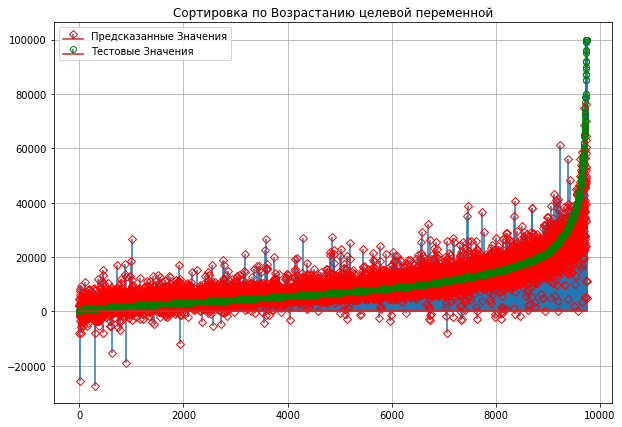

In [ ]:
fig=plt.figure(figsize=(10, 7))
sorted = np.argsort(y_test)
print_stem(y_predict[sorted], 'Предсказанные Значения', 'rD')
print_stem(y_test[sorted], 'Тестовые Значения', 'go')

plt.grid()
plt.title('Сортировка по Возрастанию целевой переменной')
plt.legend();

Получили неплохой результат

## 2. Различные типы предварительной обработки

### 2.1. Нормализация

In [ ]:
DF_norm  = df_num.copy()
Xmin = df[num_columns].min()
Xmax = df[num_columns].max()

DF_norm[num_columns] = (df[num_columns]- Xmin)/( Xmax - Xmin)

In [ ]:
DF_norm.head(3)

,Year,Distance,Engine_capacity(cm3),Price(euro),km_year,Price_mean_make
0,0.80,0.194999,0.333333,0.075651,0.354533,0.178389
1,0.86,0.134999,0.270833,0.083667,0.337487,0.113412
2,0.82,0.109999,0.270833,0.063627,0.219984,0.113412


Pазбиваем на тестовую и тренировочную 

In [ ]:
X_norm, y_norm = DF_norm.drop(columns = ['Price(euro)']).values, DF_norm['Price(euro)'].values
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_norm, y_norm, test_size=0.3, random_state=42)

Строим модель

In [ ]:
LR_norm = make_pipeline(PolynomialFeatures(degree=3), Lasso(alpha=0.00001))
LR_norm.fit(X_train_norm, y_train_norm)


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.434e+00, tolerance: 2.028e-02
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('lasso', Lasso(alpha=1e-05))])

Смотрим результат

In [ ]:
y_predict_norm=LR_norm.predict(X_test_norm)

print('Ошибка на тестовых данных')
print('MSE: %.1f' % mse(y_test_norm, y_predict_norm))
print('RMSE: %.1f' % mse(y_test_norm, y_predict_norm,squared=False))
print('R2 : %.4f' %  r2_score(y_test_norm, y_predict_norm))
print( y_norm.max()-y_norm.min()) # разброс значений

Ошибка на тестовых данных
MSE: 0.0
RMSE: 0.0
R2 : 0.7414
1.0


Визуализация Тестовых и Предсказанных значений

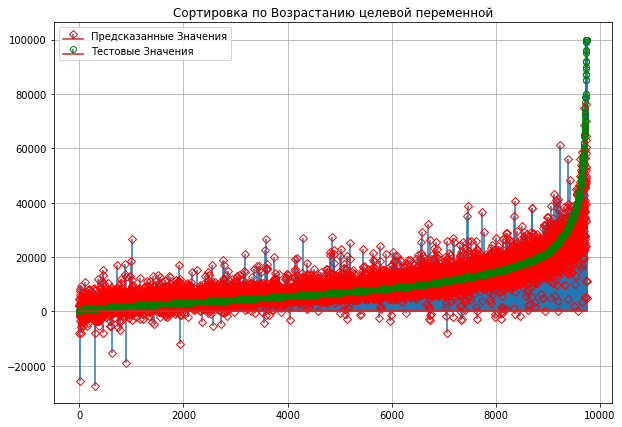

In [ ]:
fig=plt.figure(figsize=(10, 7))
sorted = np.argsort(y_test_norm)
print_stem(y_predict[sorted], 'Предсказанные Значения', 'rD')
print_stem(y_test[sorted], 'Тестовые Значения', 'go')

plt.grid()
plt.title('Сортировка по Возрастанию целевой переменной')
plt.legend();

После нормализации показатели модели улучшились

### 2.2. Стандартизация

In [ ]:
#Стандартизация, или z-нормировка для числовых данных
DF_scaled = df_num.copy()
M = df[num_columns].mean()
STD = df[num_columns].std()
DF_scaled[num_columns] = (df[num_columns]-M)/STD
DF_scaled.head(2)


,Year,Distance,Engine_capacity(cm3),Price(euro),km_year,Price_mean_make
0,0.383647,0.142253,-0.110171,-0.174700,0.389158,0.050383
1,0.797815,-0.471631,-0.602326,-0.090635,0.274376,-0.647607


Pазбиваем на тестовую и тренировочную, обучаем и смотрим на результат

In [ ]:
X_scat, y_scat= DF_scaled.drop(columns = ['Price(euro)']).values, DF_scaled['Price(euro)'].values
X_train_scat, X_test_scat, y_train_scat, y_test_scat = train_test_split(X_scat, y_scat, test_size=0.3, random_state=42)

scaler  = MinMaxScaler()
scaler.fit_transform(X_train_scat)
X_train_scat = scaler.transform(X_train_scat) 
X_test_scat = scaler.transform(X_test_scat) 

In [ ]:
LR_scat = make_pipeline(PolynomialFeatures(degree=3), Lasso(alpha=0.00001))
LR_scat.fit(X_train_scat, y_train_scat)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.306e+03, tolerance: 2.231e+00
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('lasso', Lasso(alpha=1e-05))])

In [ ]:
y_predict_scat=LR_scat.predict(X_test_scat)

print('Ошибка на тестовых данных')
print('MSE: %.1f' % mse(y_test_scat, y_predict_scat))
print('RMSE: %.1f' % mse(y_test_scat, y_predict_scat,squared=False))
print('R2 : %.4f' %  r2_score(y_test_scat, y_predict_scat))
print( y_scat.max()-y_scat.min()) # разброс значений

Ошибка на тестовых данных
MSE: 0.3
RMSE: 0.5
R2 : 0.7518
10.487009984996986


Модель стала работать еще лучше

### 2.3. Анализируем веса

In [ ]:
LR = LinearRegression()
LR.fit(X_train_scat, y_train_scat)

LinearRegression()

Смотрим результат

In [ ]:
y_predict=LR.predict(X_test_scat)

print('Ошибка на тестовых данных')
print('MSE: %.1f' % mse(y_test_scat, y_predict))
print('RMSE: %.1f' % mse(y_test_scat, y_predict,squared=False))
print('R2 : %.4f' %  r2_score(y_test_scat, y_predict))
print( y_scat.max()-y_scat.min()) # разброс значений

Ошибка на тестовых данных
MSE: 0.5
RMSE: 0.7
R2 : 0.5280
10.487009984996986


In [ ]:
def weights_vis(B, B0, features_names): #Визуализация весов
    numbers = np.arange(0,len(features_names)+1)
    Bs = np.hstack([B0,B])
    tick_labels = ['B'+str(num) for num in numbers]
    cc=['']*len(numbers)
    for n,val in enumerate(Bs):
        if val<0:
            cc[n]='red'
        elif val>=0:
            cc[n]='blue'

    plt.bar(x = numbers, height = Bs, color = cc)
    plt.xticks(np.arange(0,len(features_names)+1),np.hstack(['b0', features_names]),rotation = 45 );

In [ ]:
B0=LR.intercept_
B=LR.coef_
features_names = DF_scaled.drop(columns = ['Price(euro)']).columns

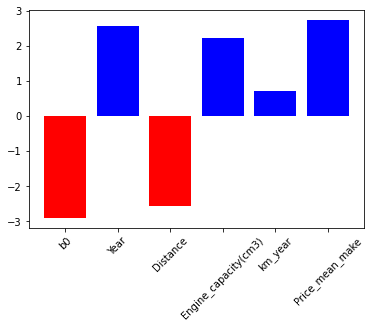

In [ ]:
weights_vis(B, B0, features_names)

Показатель дистанции имеет отрицательный вес - т.е. чем больше пробег, тем цена ниже, практически одинаковый положительный вес на цену авто имеет год выпуска и Engine_capacity(cm3). Самый большой положительный вес имеет созданный признак - цена от категории авто

### 2.4. Добавляем категориальные признаки

In [ ]:
df_dum = df.copy()
df_dum = pd.get_dummies(df_dum[cat_columns])
df_dum

,Make_Alfa Romeo,Make_Audi,Make_BMW,Make_Chevrolet,Make_Chrysler,Make_Citroen,Make_Dacia,Make_Daewoo,Make_Daihatsu,Make_Dodge,...,Fuel_type_Electric,Fuel_type_Hybrid,Fuel_type_Metan/Propan,Fuel_type_Petrol,Fuel_type_Plug-in Hybrid,Transmission_Automatic,Transmission_Manual,km_year_q_average_mileage,km_year_q_high_mileage,km_year_q_little_mileage
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32469,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,0
32470,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
32471,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,1,0,0
32472,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


Добавляем колонки со стандартизацией

In [ ]:
df_dum['Year'] = DF_scaled['Year']
df_dum['Distance'] = DF_scaled['Distance']
df_dum['Engine_capacity(cm3)'] = DF_scaled['Engine_capacity(cm3)']
df_dum['Price(euro)'] = DF_scaled['Price(euro)']
df_dum['km_year'] = DF_scaled['km_year']
df_dum['Price_mean_make'] = DF_scaled['Price_mean_make']
df_dum.head(2)

,Make_Alfa Romeo,Make_Audi,Make_BMW,Make_Chevrolet,Make_Chrysler,Make_Citroen,Make_Dacia,Make_Daewoo,Make_Daihatsu,Make_Dodge,...,Transmission_Manual,km_year_q_average_mileage,km_year_q_high_mileage,km_year_q_little_mileage,Year,Distance,Engine_capacity(cm3),Price(euro),km_year,Price_mean_make
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0.383647,0.142253,-0.110171,-0.174700,0.389158,0.050383
1,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0.797815,-0.471631,-0.602326,-0.090635,0.274376,-0.647607


К сожалению при попытке обучения гуг сообщает об отказе работы в связи с тем, что переполнено ОЗУ. Итого: последний датафрейм сохраняю и итоговое обучение модели буду проводить в другом колабе

In [ ]:
df_dum.to_csv('/content/itog.csv',index=False)